In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import TimeSeries, LombScargle
from astropy.time import Time
from astropy import units as u

In [2]:
from astroquery.gaia import Gaia
from astropy.table import Table, QTable

In [3]:
query = f"SELECT vari.* \
FROM gaiadr3.vari_summary as vari \
WHERE source_id = '5276980236450011264'" # eclipsing binary

job     = Gaia.launch_job_async(query, output_format='fits')
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 1


solution_id,source_id,num_selected_g_fov,mean_obs_time_g_fov,time_duration_g_fov,min_mag_g_fov,max_mag_g_fov,mean_mag_g_fov,median_mag_g_fov,range_mag_g_fov,trimmed_range_mag_g_fov,std_dev_mag_g_fov,skewness_mag_g_fov,kurtosis_mag_g_fov,mad_mag_g_fov,abbe_mag_g_fov,iqr_mag_g_fov,stetson_mag_g_fov,std_dev_over_rms_err_mag_g_fov,outlier_median_g_fov,num_selected_bp,mean_obs_time_bp,time_duration_bp,min_mag_bp,max_mag_bp,mean_mag_bp,median_mag_bp,range_mag_bp,trimmed_range_mag_bp,std_dev_mag_bp,skewness_mag_bp,kurtosis_mag_bp,mad_mag_bp,abbe_mag_bp,iqr_mag_bp,stetson_mag_bp,std_dev_over_rms_err_mag_bp,outlier_median_bp,num_selected_rp,mean_obs_time_rp,time_duration_rp,min_mag_rp,max_mag_rp,mean_mag_rp,median_mag_rp,range_mag_rp,trimmed_range_mag_rp,std_dev_mag_rp,skewness_mag_rp,kurtosis_mag_rp,mad_mag_rp,abbe_mag_rp,iqr_mag_rp,stetson_mag_rp,std_dev_over_rms_err_mag_rp,outlier_median_rp,in_vari_classification_result,in_vari_rrlyrae,in_vari_cepheid,in_vari_planetary_transit,in_vari_short_timescale,in_vari_long_period_variable,in_vari_eclipsing_binary,in_vari_rotation_modulation,in_vari_ms_oscillator,in_vari_agn,in_vari_microlensing,in_vari_compact_companion
,,,d,d,mag,mag,mag,mag,mag,mag,mag,,,mag,,mag,,,,,d,d,mag,mag,mag,mag,mag,mag,mag,,,mag,,mag,,,,,d,d,mag,mag,mag,mag,mag,mag,mag,,,mag,,mag,,,,,,,,,,,,,,,
int64,int64,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
375316653866487564,5276980236450011264,58,2013.1931714878135,998.48425,11.334662,11.443022,11.383945,11.382429,0.10835955,0.09366739,0.032661688,0.020925302,-1.4467874,0.04184336,1.0912389,0.060083285,18.793594,18.909344,99.96249,57,2019.7503349326407,998.48425,11.579723,11.700793,11.635441,11.637726,0.121069774,0.095861584,0.03339245,-0.050336536,-1.2738844,0.04244779,1.093535,0.05653319,19.195553,32.65899,60.77243,57,2004.7923276177944,963.2496,10.923776,11.037533,10.977228,10.976721,0.11375719,0.09226703,0.032722253,-0.08083688,-1.4059951,0.044895735,1.0421574,0.059355184,19.10532,34.630733,58.573185,True,False,False,False,True,False,True,False,False,False,False,False


In [4]:
retrieval_type = 'EPOCH_PHOTOMETRY'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink  = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, format='votable', output_file=None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')


The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 5276980236450011264.xml


In [5]:
product     = datalink[dl_keys[0]][0]
product_tb  = product.to_table()                  # Export to Astropy Table object.
source_ids  = list(set(product_tb['source_id']))  # Detect source_ids.
print(f' There is data for the following Source ID:')
for source_id in source_ids:
    print(f'* {source_id}')

 There is data for the following Source ID:
* 5276980236450011264


### Light Curve Analysis

In [6]:
gaia_t, gaia_f, gaia_m = product_tb['time'], product_tb['flux'], product_tb['mag']
gaia_g, gaia_r, gaia_b = product_tb['band']=='G', product_tb['band']=='RP', product_tb['band']=='BP'
gaia_gmed, gaia_rmed, gaia_bmed = np.nanmedian(gaia_m[gaia_g]), np.nanmedian(gaia_m[gaia_r]), np.nanmedian(gaia_m[gaia_b])

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


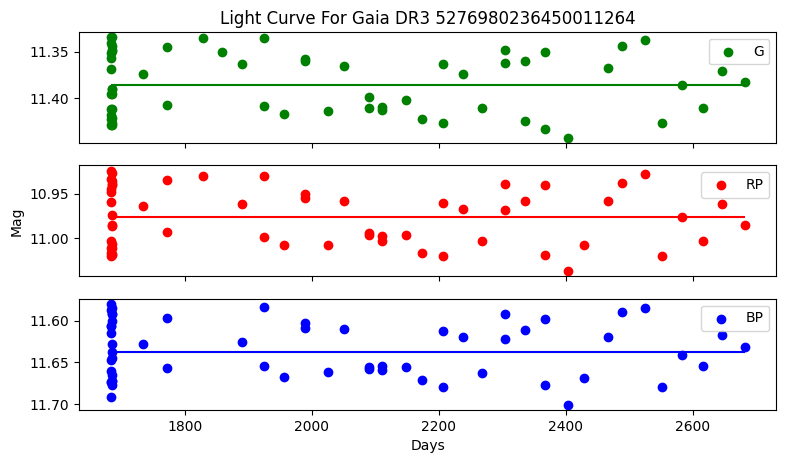

In [7]:
fig, ax = plt.subplots(3, figsize=[9,5], sharex=True, dpi=100)

ax[0].scatter(gaia_t[gaia_g], gaia_m[gaia_g], color='g', label='G')
ax[0].hlines(gaia_gmed, gaia_t[gaia_g][0], gaia_t[gaia_g][-1], color='g')
ax[1].scatter(gaia_t[gaia_r], gaia_m[gaia_r], color='r', label='RP')
ax[1].hlines(gaia_rmed, gaia_t[gaia_r][0], gaia_t[gaia_r][-1], color='r')
ax[2].scatter(gaia_t[gaia_b], gaia_m[gaia_b], color='b', label='BP')
ax[2].hlines(gaia_bmed, gaia_t[gaia_b][0], gaia_t[gaia_b][-1], color='b')


ax[0].set_title(f'Light Curve For Gaia DR3 {source_ids[0]}')
ax[2].set_xlabel('Days')
ax[1].set_ylabel('Mag')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

In [8]:
gaia_gtime, gaia_rtime, gaia_btime = Time(gaia_t[gaia_g] + 2455197.5, format='jd'), Time(gaia_t[gaia_r] + 2455197.5, format='jd'), Time(gaia_t[gaia_b] + 2455197.5, format='jd')
gaia_gflux, gaia_rflux, gaia_bflux = np.array(gaia_f[gaia_g])*u.electron/u.s, np.array(gaia_f[gaia_r])*u.electron/u.s, np.array(gaia_f[gaia_b])*u.electron/u.s
gaia_gmag, gaia_rmag, gaia_bmag = np.array(gaia_m[gaia_g])*u.mag, np.array(gaia_m[gaia_r])*u.mag, np.array(gaia_m[gaia_b])*u.mag

In [9]:
gaia_gts = TimeSeries(time = gaia_gtime, data={'mag' : gaia_gmag})
gaia_rts = TimeSeries(time = gaia_rtime, data={'mag' : gaia_rmag})
gaia_bts = TimeSeries(time = gaia_btime, data={'mag' : gaia_bmag})

Text(0, 0.5, 'Power')

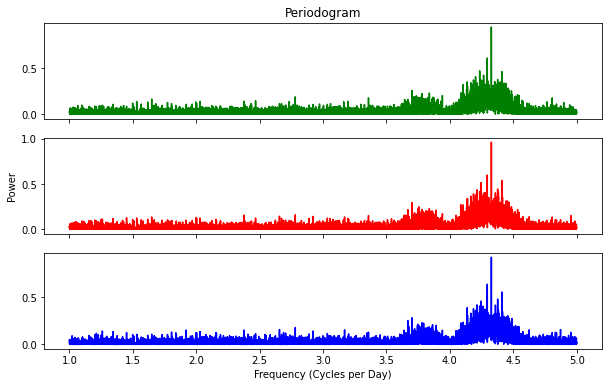

In [10]:
gaia_gfreq, gaia_gpower = LombScargle(gaia_gtime, gaia_gmag.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=5/u.d)
gaia_rfreq, gaia_rpower = LombScargle(gaia_rtime, gaia_rmag.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=5/u.d)
gaia_bfreq, gaia_bpower = LombScargle(gaia_btime, gaia_bmag.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=5/u.d)

gaia_gbestfreq = gaia_gfreq[np.argmax(gaia_gpower)]
gaia_rbestfreq = gaia_rfreq[np.argmax(gaia_rpower)]
gaia_bbestfreq = gaia_bfreq[np.argmax(gaia_bpower)]

fig, ax = plt.subplots(3, figsize=[10,6], sharex=True)

ax[0].plot(gaia_gfreq, gaia_gpower, color='g')
ax[1].plot(gaia_rfreq, gaia_rpower, color='r')
ax[2].plot(gaia_bfreq, gaia_bpower, color='b')
ax[0].set_title('Periodogram')
ax[2].set_xlabel('Frequency (Cycles per Day)')
ax[1].set_ylabel('Power')

In [11]:
print(1/gaia_gbestfreq)
print(1/gaia_rbestfreq)
print(1/gaia_bbestfreq)

0.23111541559146917 d
0.2311047165719989 d
0.2311047166144291 d


We use double the period because we are trying to fit a double gaussian

In [12]:
gaia_gts_folded = gaia_gts.fold(period=2./gaia_gbestfreq, normalize_phase=True, epoch_phase=0)
gaia_rts_folded = gaia_rts.fold(period=2./gaia_gbestfreq, normalize_phase=True, epoch_phase=0)
gaia_bts_folded = gaia_bts.fold(period=2./gaia_gbestfreq, normalize_phase=True, epoch_phase=0)

Text(0, 0.5, 'Residual Mag')

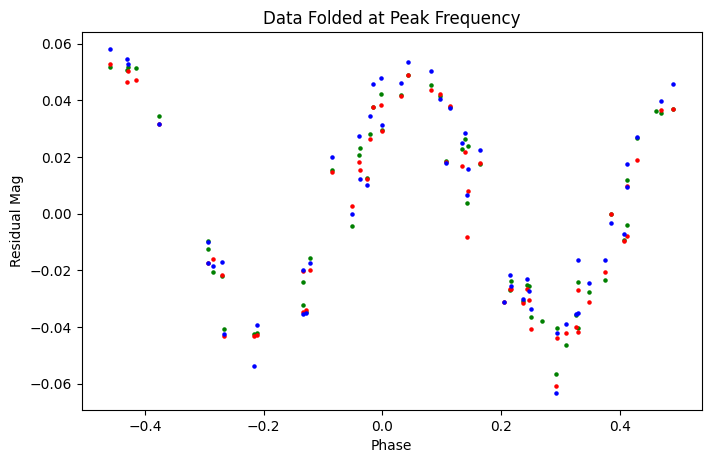

In [13]:
fig = plt.figure(figsize=(8,5), dpi=100)

plt.scatter(gaia_gts_folded['time'], gaia_gmed*u.mag - gaia_gts_folded['mag'], c = 'g', s=5)
plt.scatter(gaia_rts_folded['time'], gaia_rmed*u.mag - gaia_rts_folded['mag'], c = 'r', s=5)
plt.scatter(gaia_bts_folded['time'], gaia_bmed*u.mag - gaia_bts_folded['mag'], c = 'b', s=5)
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Residual Mag')

In [14]:
from scipy.optimize import curve_fit

In [15]:
def negDoubleGaussian(x, mu1, sig1, d1, mu2, sig2, d2, b):
    g1 = d1*np.exp(-np.power(x - mu1, 2.) / (2 * np.power(sig1, 2.)))
    g2 = d2*np.exp(-np.power(x - mu2, 2.) / (2 * np.power(sig2, 2.)))
    ndg = -g1 - g2 + b
    return ndg

In [16]:
p0 = np.array([-0.2, 0.2, 0.1, 0.3, 0.2, 0.1, 0.06])
p1, cov1 = curve_fit(negDoubleGaussian, gaia_gts_folded['time'].value, gaia_gmed - gaia_gts_folded['mag'].value, p0)
p2, cov2 = curve_fit(negDoubleGaussian, gaia_rts_folded['time'].value, gaia_rmed - gaia_rts_folded['mag'].value, p0)
p3, cov3 = curve_fit(negDoubleGaussian, gaia_bts_folded['time'].value, gaia_bmed - gaia_bts_folded['mag'].value, p0)

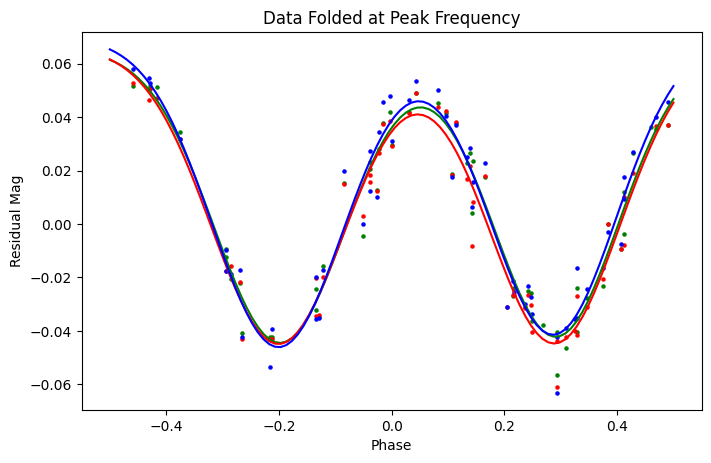

In [17]:
fig = plt.figure(figsize=(8,5), dpi=100)

plt.scatter(gaia_gts_folded['time'], gaia_gmed*u.mag - gaia_gts_folded['mag'], c = 'g', s=5)
plt.scatter(gaia_rts_folded['time'], gaia_rmed*u.mag - gaia_rts_folded['mag'], c = 'r', s=5)
plt.scatter(gaia_bts_folded['time'], gaia_bmed*u.mag - gaia_bts_folded['mag'], c = 'b', s=5)
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Residual Mag')

xs = np.linspace(-0.5, 0.5, 100)
plt.plot(xs, negDoubleGaussian(xs, p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6]), c='g')
plt.plot(xs, negDoubleGaussian(xs, p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6]), c='r')
plt.plot(xs, negDoubleGaussian(xs, p3[0], p3[1], p3[2], p3[3], p3[4], p3[5], p3[6]), c='b')